In [ ]:
#@title Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import lightgbm as lgb
from sklearn.model_selection import train_test_split


from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
#@title Load Data
PATH = r'/content/drive/My Drive/zaloai/'
df = pd.read_csv(PATH +  'final.csv')
df_mp3 = pd.read_csv(PATH + 'data_mp3.csv')
# df_word = pd.read_csv(PATH + 'word_importance.csv')
df_meta = pd.read_csv(PATH + 'finaldata/train_metadata.csv')
df_tempo =  pd.read_csv(PATH + 'finaldata/train_tempo.csv',index_col=0)
df_train_lyric = pd.read_csv(PATH + 'finaldata/train_lyric.csv').fillna(0)

df_train_origin = pd.read_csv(r'/content/drive/My Drive/ZaloAI/Dataset/train_info.tsv', sep = '\t')




df = pd.merge(df, df_train_lyric, on = 'ID', how='left').fillna(-1)
df = pd.merge(df_mp3, df, on='ID', how='left')
# df = pd.merge(df, df_word, on = 'ID', how='left')
df = pd.merge(df,df_meta[['ID','duration', 'audio_offset','filesize']], on ='ID', how = 'left')
df = pd.merge(df, df_tempo, on = 'ID', how='left')



df_train_origin['release_time'] = pd.to_datetime(df_train_origin['release_time'])
df['year'] = df_train_origin['release_time'].apply(lambda x: x.year)

In [ ]:
#@title Minh's Attribute
import pickle

pickle_in = open( r'/content/drive/My Drive/Zaloai.plk',"rb")
new_df = pickle.load(pickle_in)

## Self Compose or Not 
new_df['is_self_compose'] = 0
index = new_df[new_df['artist_id'] == new_df['composers_id']].index.values
new_df.loc[index,'is_self_compose'] = 1 



temp = new_df[['ID','title','is_self_compose','artist_id','composers_id']]
temp = pd.merge(temp, df, on='ID', how='left')


## Is International Music 
indexs = temp.loc[new_df['composers_100103'] == 1]['number_composers'].index.values 
temp['International_Musics'] = 0
temp.loc[indexs,'International_Musics'] = 1

indexs = temp.loc[new_df['composers_100103'] == 1]['number_composers'].index.values 
temp.loc[indexs,'number_composers'] = temp.loc[indexs,'number_composers'] - 1

## Is Various Composer 
indexs = temp.loc[new_df['composers_101978'] == 1]['number_composers'].index.values 
temp.loc[indexs,'number_composers'] = 10


## Beat, LK and Remix 
temp['lower_title'] = temp['title'].str.lower()

temp['beat'] = 0
temp.loc[temp['lower_title'].str.contains("beat"),'beat'] = 1


temp['lk'] = 0
temp.loc[temp['lower_title'].str.contains("liên khúc"),'lk'] = 1


temp['remix'] = 0
temp.loc[temp['lower_title'].str.contains("remix"),'remix'] = 1

## Artist ID 
temp['artist_newest'] = temp['artist_id'].apply(max)
temp['artist_oldest'] = temp['artist_id'].apply(min)

def removeComposerID(list_):
    try: 
        list_.remove('100103')
    except: 
        pass
    
    try:
        list_.remove('101978')
    except: 
        pass 

    return list_

temp['composers_id'].apply(removeComposerID)


## Composer ID 
def maxComposer(list_):
    try: 
        return max(list_)
    except: 
        return 0 

def minComposer(list_):
    try: 
        return min(list_)
    except: 
        return 0 


temp['composer_newest'] = temp['composers_id'].apply(maxComposer)
temp['composer_oldest'] = temp['composers_id'].apply(minComposer)

In [ ]:
df_mp3.columns[50:60]

Index(['spectral_rolloff_0.05', 'spectral_rolloff_0.25',
       'spectral_rolloff_0.5', 'spectral_rolloff_0.75',
       'spectral_rolloff_0.95', 'spectral_rolloff_mean',
       'spectral_rolloff_std', 'mfcc_1_0.05', 'mfcc_1_0.25', 'mfcc_1_0.5'],
      dtype='object')

In [ ]:
temp['origin_title'] = temp['lower_title']
temp['origin_title'] = temp['origin_title'].apply(
                                            lambda x: re.sub(' (\(.*\))','',x) )
index = temp['lower_title'].str.contains("remix")
temp['origin_title']

In [ ]:
df_test = pd.read_csv(r'/content/drive/My Drive/ZaloAI/Dataset/test_info.tsv', sep = '\t')
df_test['lower_title'] = df_test['title'].str.lower()

df_test['origin_title'] = df_test['lower_title']
df_test['origin_tit le'] = df_test['origin_title'].apply(
                                            lambda x: re.sub(' (\(.*\))','',x) )
index = df_test['lower_title'].str.contains("remix")
df_test['origin_title']

In [ ]:
test_title  = df_test['origin_title']
train_title = temp['origin_title']

In [ ]:
for t in test_title[0:100]:
    print(t)
    print(temp[train_title.str.contains(t)]['title'])

In [ ]:
#@title Metadata 
df_full_train_meta = pd.read_csv(PATH + 'finaldata/minh_train_metadata.csv',index_col=0)
df_full_train_meta.loc[df_full_train_meta['date'] == 2917,'date'] = 2017.0

# Is in Album or Not
temp['album'] = 1 
temp.loc[df_full_train_meta['album'].isna(),'album'] = 0

# Have Lyrics 
temp['lyric'] = 1 
temp.loc[df_full_train_meta['USLT::eng'].isna(),'lyric'] = 0

# Various Artist 
temp['album_various_artist'] = 0 
temp.loc[df_full_train_meta['albumartist'] == 'Various Artists','album_various_artist'] = 1

# df_full_train_meta['encodersettings'].unique()
# Old Song 
temp['is_old_song'] = 0
temp.loc[temp['year'] > df_full_train_meta['date'],'year'] = 1


# Count Num Word 
import re 

def countNumDifferentWord(lyric):
    try:
        string = lyric.lower() 
        string = re.sub('[\r\n]+', '', string)
        string = re.sub(r'[+\-"():\\\/\^<>\.,;!?]'," ",string)
        return len(set(string.split()))
    except: 
        return 0 

temp['num_word'] = df_full_train_meta['USLT::eng'].apply(countNumDifferentWord)

In [ ]:
df

,ID,zcr_0.05,zcr_0.25,zcr_0.5,zcr_0.75,zcr_0.95,zcr_mean,zcr_std,energy_0.05,energy_0.25,energy_0.5,energy_0.75,energy_0.95,energy_mean,energy_std,energy_entropy_0.05,energy_entropy_0.25,energy_entropy_0.5,energy_entropy_0.75,energy_entropy_0.95,energy_entropy_mean,energy_entropy_std,spectral_centroid_0.05,spectral_centroid_0.25,spectral_centroid_0.5,spectral_centroid_0.75,spectral_centroid_0.95,spectral_centroid_mean,spectral_centroid_std,spectral_spread_0.05,spectral_spread_0.25,spectral_spread_0.5,spectral_spread_0.75,spectral_spread_0.95,spectral_spread_mean,spectral_spread_std,spectral_entropy_0.05,spectral_entropy_0.25,spectral_entropy_0.5,spectral_entropy_0.75,...,mfcc1_scale,mfcc2_scale,mfcc3_scale,mfcc4_scale,mfcc5_scale,mfcc6_scale,mfcc7_scale,mfcc8_scale,mfcc9_scale,mfcc10_scale,mfcc11_scale,mfcc12_scale,mfcc13_scale,mfcc14_scale,mfcc15_scale,mfcc16_scale,mfcc17_scale,mfcc18_scale,mfcc19_scale,mfcc20_scale,label,dk,chorus,rap,verse,bridge,sentences,words,characters,sentences_unique,words_unique,characters_unique,sentences_duplicate,words_duplicate,characters_duplicate,duration,audio_offset,filesize,tempo,year
0,1073748245,0.01928,0.03153,0.04377,0.05874,0.09844,0.05016,0.03904,0.00173,0.01975,0.05660,0.08292,0.11381,0.05471,0.03650,3.11571,3.24131,3.27917,3.30081,3.31538,3.25424,0.09789,0.07411,0.09721,0.11767,0.14467,0.22285,0.12763,0.04649,0.11939,0.14963,0.17069,0.19392,0.23191,0.17286,0.03413,0.04222,0.10813,0.18950,0.33440,...,-0.201697,0.855821,-0.286212,0.006888,0.625555,0.408783,2.172321,-0.482149,1.136286,0.698918,-0.602624,0.050437,-0.767116,-0.590079,-0.599829,0.539466,0.880667,2.451081,1.844365,0.015782,7,0.0,0.0,0.0,0.0,0.0,39.0,274.0,1168.0,32.0,122.0,83.0,7.0,152.0,1085.0,362.804910,25810.0,5825828.0,161.499023,2017
1,1073751978,0.02064,0.03992,0.05874,0.07916,0.11907,0.06284,0.03310,0.00246,0.03689,0.06409,0.09007,0.12765,0.06435,0.03762,2.91487,3.13587,3.21769,3.26462,3.30042,3.16871,0.18795,0.09883,0.13650,0.16477,0.18961,0.25165,0.16670,0.04647,0.14572,0.17340,0.18980,0.20604,0.23173,0.18977,0.02746,0.10084,0.26362,0.44688,0.70387,...,0.914466,-1.149197,0.289374,1.122664,1.014711,1.005304,1.868203,1.647392,2.815319,0.837348,0.637795,1.252541,0.295072,1.351417,0.812182,1.445198,0.976502,1.809661,1.714939,1.733300,3,0.0,0.0,0.0,0.0,0.0,38.0,167.0,771.0,30.0,101.0,68.0,8.0,66.0,703.0,242.878161,26740.0,3909579.0,64.599609,2017
2,1073835561,0.01656,0.03856,0.06010,0.09027,0.16838,0.07225,0.05272,0.00202,0.02444,0.07841,0.12758,0.17588,0.08022,0.05840,2.62637,3.10171,3.21192,3.26501,3.30567,3.12343,0.27975,0.07944,0.12572,0.16766,0.21000,0.29052,0.17154,0.06476,0.12376,0.16701,0.19204,0.20948,0.23295,0.18556,0.03828,0.04170,0.19697,0.43975,0.82376,...,0.221216,-1.582708,-0.764945,-1.772133,-0.180000,-0.684258,0.017617,0.406455,0.146352,0.898436,0.995214,1.653996,0.789338,0.303839,-0.400869,0.533095,1.153336,0.995516,0.682904,1.441798,6,0.0,0.0,0.0,0.0,0.0,17.0,95.0,428.0,16.0,47.0,57.0,1.0,48.0,371.0,238.982563,19510.0,3840073.0,191.406250,2017
3,1073856553,0.01814,0.03243,0.04377,0.05942,0.09904,0.05160,0.04154,0.00130,0.02509,0.04699,0.07232,0.10731,0.05016,0.03293,3.01794,3.20987,3.26371,3.29290,3.31224,3.22539,0.13492,0.06658,0.09670,0.12158,0.14850,0.20245,0.12696,0.04533,0.11300,0.14978,0.17042,0.18870,0.21673,0.16868,0.03161,0.01787,0.08889,0.19134,0.36621,...,-0.293788,0.291656,-0.125908,-1.019447,-0.209655,-0.235916,1.447841,0.122593,1.509914,1.419979,0.162721,0.859509,0.035735,0.353345,0.376353,0.463554,0.918936,2.464313,1.779687,1.369814,2,0.0,0.0,0.0,0.0,0.0,2.0,184.0,804.0,2.0,122.0,73.0,0.0,62.0,731.0,327.823035,20250.0,5261039.0,129.199219,2017
4,1073929630,0.01297,0.02835,0.04513,0.06532,0.11354,0.05145,0.03372,0.00381,0.02538,0.04657,0.08115,0.13189,0.05606,0.04008,2.94755,3.16328,3.22814,3.27393,3.30535,3.19037,0.14517,0.08967,0.12465,0.15819,0.19945,0.25623,0.16475,0.05451,0.15165,0.18248,0.20365,0.22449,0.24942,0.20270,0.03122,0.04613,0.13130,0.25537,0.45776,...,0.307005,-0.270720,1

In [ ]:
#@title Assemble Attribute { vertical-output: true }
# drop = ['spectral_centroid_0.05', 'spectral_centroid_0.25',
#        'spectral_centroid_0.5', 'spectral_centroid_0.75',
#        'spectral_centroid_0.95', 'spectral_centroid_mean',
#        'spectral_centroid_std', 'spectral_spread_0.05', 'spectral_spread_0.25',
#        'spectral_spread_0.5', 'spectral_spread_0.75', 'spectral_spread_0.95',
#        'spectral_spread_mean', 'spectral_spread_std']

# mp3_attributes =  list(df_mp3.columns[1:22]) 

# lyric_attributes = list(df_train_lyric.columns[1:]) 

lyric_attributes =  [
                    # 'dk',
                    # 'chorus',
                    'rap',
                    # 'verse',
                    # 'bridge',
                    # 'sentences_duplicate',
                     ]

mp3_attributes =  ['zcr_mean',
                   'energy_mean',
                   'energy_entropy_mean',
                   'spectral_centroid_mean',
                   'spectral_spread_mean',
                   'spectral_entropy_mean',
                   'spectral_flux_mean',
                   'spectral_rolloff_mean',
                   ]

categorical_attributes =  [
                          'Min', 
                          'number_artists', 'number_composers', 
                          'number_punctuations_encode',
                          'length_title_not_punc_encode', 
                          'Hour_encode', 
                          'DayofWeek_encode',
                          'Month', 'Day', #'artist_id_encode', # 'frequence_artist',
                          'genre_encode',
                          'International_Musics',
                          'is_self_compose',
                          'beat',
                          'lk',
                          'remix',
                          'album',
                          'lyric',
                          'album_various_artist',
                          'is_old_song',
                          ]

continuous_attributes = [
                        #  'ID',
                         'duration', 
                         'audio_offset',
                         'filesize',
                         'num_word',
                         'artist_newest',
                         'artist_oldest',
                         'composer_newest',
                         'composer_oldest'
                         ]\
                         + mp3_attributes # + lyric_attributes

attributes = categorical_attributes + continuous_attributes
             #+ minh_attributes + mp3_attributes #+ word_importance_attributes
# selected_attributes = attributes + mp3_attributes

my_df = temp['ID'].dropna().reset_index(drop = True)
train_df = temp[attributes + ['label']].dropna().reset_index(drop = True)

for att in categorical_attributes:
  train_df[att] = train_df.loc[:,att].astype('category')

# attributes

In [ ]:
attributes

['Min',
 'number_artists',
 'number_composers',
 'number_punctuations_encode',
 'length_title_not_punc_encode',
 'Hour_encode',
 'DayofWeek_encode',
 'Month',
 'Day',
 'genre_encode',
 'International_Musics',
 'is_self_compose',
 'beat',
 'lk',
 'remix',
 'album',
 'lyric',
 'album_various_artist',
 'is_old_song',
 'duration',
 'audio_offset',
 'filesize',
 'num_word',
 'artist_newest',
 'artist_oldest',
 'composer_newest',
 'composer_oldest',
 'zcr_mean',
 'energy_mean',
 'energy_entropy_mean',
 'spectral_centroid_mean',
 'spectral_spread_mean',
 'spectral_entropy_mean',
 'spectral_flux_mean',
 'spectral_rolloff_mean']

In [ ]:
len(train_df)

9068

# Tree based model

In [ ]:
lgb_params = dict(
    objective = 'regression_l2',
    learning_rate = 0.005,
    num_leaves = 10,
    max_depth = -1,
    bagging_fraction = 0.8534,
    bagging_freq = 2,
    feature_fraction = 0.5969,
    lambda_l1 = 1.587,
    num_class = 10,
    lambda_l2 = 0.4037,
    # metric = 'auc','logloss',
    min_child_weight = 16.78,
    min_split_gain =  0.08554,
    seed = 42 # Change for better luck! :)
)

In [ ]:
y = df['label']
y.loc[df['label'] == 10] = 0 

X_train, X_valid, y_train, y_valid = train_test_split(train_df.values, y, 
                                                      random_state = 0,
                                                      test_size=0.2)

train_set=lgb.Dataset(X_train, label=y_train, feature_name=attributes ,categorical_feature=categorical_attributes)
valid_set=lgb.Dataset(X_valid, label=y_valid, feature_name=attributes, categorical_feature=categorical_attributes)

model = lgb.train(lgb_params, train_set, valid_sets=[train_set, valid_set], num_boost_round=100000,
                           early_stopping_rounds=20000, verbose_eval=10000,categorical_feature=categorical_attributes)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20000 rounds.
[10000]	training's multi_logloss: 0.75711	valid_1's multi_logloss: 1.93204
[20000]	training's multi_logloss: 0.462279	valid_1's multi_logloss: 2.0147
Early stopping, best iteration is:
[5502]	training's multi_logloss: 1.06262	valid_1's multi_logloss: 1.91174


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = model.predict(X_valid, num_iteration = model.best_iteration)


In [ ]:
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))

In [ ]:
y_pred = [p if p != 0 else 10 for p in predictions]  

In [ ]:
rms = sqrt(mean_squared_error(y_valid, y_pred))
rms

3.7476196046574404

In [ ]:
y_pred = model.predict(train_df.values, 
                       num_iteration = model.best_iteration)

In [ ]:
pred_df = pd.DataFrame({'ID' : df['ID'].values, 
                        'model_pred_1' : y_pred,})

In [ ]:
shuffle_dataset = (X1_train,X1_valid)   

In [ ]:
import pickle 
with open(r'/content/drive/My Drive/trainform_df.pkl','wb') as f:
     pickle.dump(train_df,f)

In [ ]:
with open(r'/content/drive/My Drive/pred_df.pkl','wb') as f:
    pickle.dump(pred_df,f)

with open(r'/content/drive/My Drive/shuffle_data.pkl','wb') as f:
    pickle.dump(shuffle_dataset,f)

# PipeLine 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler,Normalizer,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline 

class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    # Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    # Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

In [ ]:
Continous_Pipeline = Pipeline(steps = [('continous selector', FeatureSelector(continuous_attributes)),
                                       ('std_scaler', StandardScaler()) ,
                                        # ('std_scaler', Normalizer()) , 
                                        #   ('std_scaler', RobustScaler()) ,
                                    ]
                              )
Cat_Pipeline       = Pipeline(steps = [('cat selector', FeatureSelector(categorical_attributes)),
                                       ]
                              )

Mp3_Pipeline       = Pipeline(steps = [('mp3 selector', FeatureSelector(mp3_attributes)),
                                       ('std_scaler', StandardScaler()) ,
                                       ('PCA', PCA(n_components=5))]
                              )
Preprocessing      = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', Cat_Pipeline ), 
                                                        ( 'numerical_pipeline', Continous_Pipeline ),
                                                           # ('mp3_pipeline', Mp3_Pipeline) ] )
                                                        ])

### Testpipe Line

#### Current Best 

In [ ]:
"""
Best Attribute 
        ['Min',
        'number_artists',
        'number_composers',
        'number_punctuations_encode',
        'length_title_not_punc_encode',
        'Hour_encode',
        'DayofWeek_encode',
        'Month',
        'Day',
        'genre_encode',
        'International_Musics',
        'is_self_compose',
        'beat',
        'lk',
        'remix',
        'album',
        'lyric',
        'album_various_artist',
        'is_old_song',
        'duration',
        'audio_offset',
        'filesize',
        'num_word',
        'zcr_mean',
        'energy_mean']

Params: { 'learning_rate': 0.0038797193795682, 
          'lambda_l1': 0.7936096823955118, 
          'lambda_l2': 2.3787867957409454,
          'num_leaves': 69, 
          'feature_fraction': 0.7521707185814852, 
          'bagging_fraction': 0.3493325503266471, 
          'bagging_frequent': 1, 
          'min_split_gain': 1.955525260480716e-05, 
          'min_child_weight': 37.482091559262614, 'seed': 136}

"""

In [ ]:
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, 
                                                      random_state = 0,
                                                      test_size=0.2,)

X_train = Preprocessing.fit_transform(X_train)
X_valid = Preprocessing.transform(X_valid)

# lgb_params = {'application':'regression_l2',
#               'metric':'l2_root',
#              'learning_rate': 0.007045110825941851,
#               'lambda_l1': 2.303881820899245, 
#               'lambda_l2': 2.1576294986472857,
#               'num_leaves': 78, 
#               'feature_fraction': 0.8075682476180122,
#               'bagging_fraction': 0.3476520970730281,
#               'bagging_frequent': 16,
#               'min_split_gain': 0.00016975493654098868, 
#               'min_child_weight': 37.51201214533907,
#               'seed': 242}

# lgb_params = {'application':'regression_l2',
#               'metric':'l2_root',
#                 'learning_rate': 0.02052999575072533,
#                'lambda_l1': 1.386597259652515, 
#                'lambda_l2': 2.7155743442117086,
#                'num_leaves': 64,
#                'feature_fraction': 0.5076759098505713,
#                'bagging_fraction': 0.9235746766547196, 
#                'bagging_frequent': 12,
#                'min_split_gain': 3.0177834645632945e-05,
#                'min_child_weight': 8.690904590888618,
#                'seed': 196}

lgb_params = {'application':'regression_l2',
              'metric':'l2_root',
    'learning_rate': 0.005976053757896968,
 'lambda_l1': 1.0568823110348258, 
 'lambda_l2': 1.55326839435241,
 'num_leaves': 59,
 'feature_fraction': 0.6107130496167985, 
 'bagging_fraction': 0.21707765621212027,
 'bagging_frequent': 10,
 'min_split_gain': 3.3313398631164086e-07,
 'min_child_weight': 32.47447995484354,
 'seed': 251}



train_set=lgb.Dataset(X_train, 
                      label=y_train,
                      feature_name=attributes ,
                      categorical_feature=categorical_attributes,
                      )
valid_set=lgb.Dataset(X_valid, 
                      label=y_valid, 
                      feature_name=attributes ,
                      categorical_feature=categorical_attributes)

model = lgb.train(lgb_params, train_set, valid_sets=[train_set, valid_set], num_boost_round=10000000,
                           early_stopping_rounds=20000, verbose_eval=10000, categorical_feature=categorical_attributes)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20000 rounds.
[10000]	training's rmse: 0.193748	valid_1's rmse: 1.86051
[20000]	training's rmse: 0.135497	valid_1's rmse: 1.86152
Early stopping, best iteration is:
[9150]	training's rmse: 0.21667	valid_1's rmse: 1.86028


In [ ]:
X_pred = Preprocessing.transform(train_df)

In [ ]:
temp[['ID'] + attributes].dropna()

In [ ]:
y_pred = model.predict(X_pred)

residual = y - y_pred
pred_df = pd.DataFrame({'ID': temp[['ID'] + attributes].dropna()['ID'].values, 
                        'pred_lgb' : y_pred })
pred_df

In [ ]:
error = temp[['ID','title',] + attributes].dropna().reset_index(drop = True)

In [ ]:
error[residual > 4 ]

In [ ]:
pred_df[residual > 4 ]

In [ ]:
y[residual > 4]

In [ ]:
sns.lineplot(x=pred_df.index.values[:1000], y="label", data=df.loc[0:999]);
sns.lineplot(x=pred_df.index.values[:1000], y="pred_lgb", data=pred_df.loc[0:999]);

In [ ]:
import pickle 
with open('/content/drive/My Drive/pred_df.pkl','wb') as f:
    pickle.dump(pred_df,f)

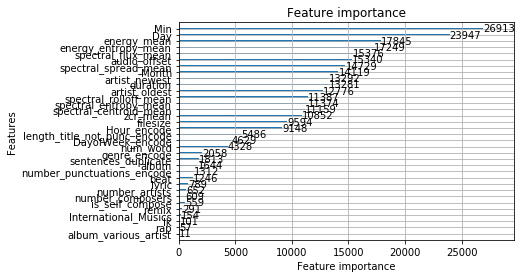

In [ ]:
lgb.plot_importance(model)
plt.show()

In [ ]:
model.save_model('/content/drive/My Drive/1.85081_lgmmodel.txt', 
                  num_iteration=model.best_iteration)

In [ ]:
bst = lgb.Booster(model_file=r'/content/drive/My Drive/1.85081_lgmmodel.txt')

# Bayesian Optimization 

In [ ]:
!pip install bayesian_optimization

In [ ]:
!pip install optuna

### Baysian_Optimization

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, 
                                                      random_state = 0,
                                                      test_size=0.2,)

X_train = Preprocessing.fit_transform(X_train)
X_valid = Preprocessing.transform(X_valid)

train_set=lgb.Dataset(X_train, label=y_train, feature_name=attributes,categorical_feature=categorical_attributes)
valid_set=lgb.Dataset(X_valid, label=y_valid, feature_name=attributes,categorical_feature=categorical_attributes)

models = []

def lgb_eval(num_leaves, feature_fraction, bagging_fraction,bagging_frequent, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = { 'application':'regression_l2',
              'metric':'l2_root'}
    params['learning_rate'] = 0.005 # learning_rate
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['bagging_frequent'] = int(round(bagging_frequent))
    params['max_depth'] = -1 # int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight

    result = lgb.train(params, 
                      train_set, valid_sets=[train_set, valid_set],
                      num_boost_round=1000000,
                      early_stopping_rounds=5000,
                      categorical_feature = categorical_attributes,
                      verbose_eval =0)

    models.append(result)

    return -result.best_score['valid_1']['rmse']

In [ ]:
from bayes_opt import BayesianOptimization

lgbBO = BayesianOptimization(lgb_eval, { #'learning_rate': (5e-3,5e-3),
                                        'num_leaves': (5, 30),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'bagging_frequent': (1, 3),
                                        'lambda_l1': (0, 3),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 20)},
                             verbose= 2,
                             random_state=0)

In [ ]:
 lgbBO.maximize(init_points=3, n_iter=40)

In [ ]:
params = lgbBO.max['params']

params['application'] ='regression_l2'
params['metric'] ='l2_root'
params['learning_rate'] = 0.0003
params["num_leaves"] = int(round(params["num_leaves"]))
params['feature_fraction'] = max(min(params['feature_fraction'], 1), 0)
params['bagging_fraction'] = max(min(params['bagging_fraction'], 1), 0)
params['max_depth'] = int(round(params['max_depth'] ))
params['lambda_l1'] = max(params['lambda_l1'], 0)
params['lambda_l2'] = max(params['lambda_l2'], 0)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, 
                                                      random_state = 0,
                                                      test_size=0.2,)

X_train = Preprocessing.fit_transform(X_train)
X_valid = Preprocessing.transform(X_valid)

train_set=lgb.Dataset(X_train, label=y_train, feature_name=attributes,categorical_feature=categorical_attributes)
valid_set=lgb.Dataset(X_valid, label=y_valid, feature_name=attributes,categorical_feature=categorical_attributes)

result = lgb.train(params, 
                   train_set, valid_sets=[train_set, valid_set],
                   num_boost_round=1000000,
                   early_stopping_rounds=5000,
                   categorical_feature = categorical_attributes,
                   verbose_eval =1000)

In [ ]:
result.save_model('/content/drive/My Drive/1.964_lgmmodel.txt', 
                  num_iteration=result.best_iteration)

In [ ]:
bst = lgb.Booster(model_file=r'/content/drive/My Drive/1.964_lgmmodel.txt')

### Optuna 

In [ ]:
y = train_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(train_df, y, 
                                                      random_state = 0,
                                                      test_size=0.2,)

X_train = Preprocessing.fit_transform(X_train)
X_valid = Preprocessing.transform(X_valid)

train_set=lgb.Dataset(X_train, label=y_train, feature_name=attributes,categorical_feature=categorical_attributes)
valid_set=lgb.Dataset(X_valid, label=y_valid, feature_name=attributes,categorical_feature=categorical_attributes)


def objective(trial):
    params = {
        'application':'regression_l2',
        'metric':'l2_root',
        # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-2),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0005, 0.1),
        'lambda_l1' : trial.suggest_uniform('lambda_l1',0,3),
        'lambda_l2' : trial.suggest_uniform('lambda_l2', 0, 3),
        'num_leaves': trial.suggest_int('num_leaves',10,100),
        'feature_fraction' : trial.suggest_uniform('feature_fraction', 0, 1),
        'bagging_fraction' : trial.suggest_uniform('bagging_fraction', 0, 1),
        'bagging_frequent' : trial.suggest_int('bagging_frequent',0,30),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-10, 1e-3),
        'min_child_weight': trial.suggest_uniform('min_child_weight', 5, 40),
        'seed' : trial.suggest_int('seed',0,1000),
    }


    # Add a callback for pruning.
    # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'rmse')
    result = lgb.train( params, 
                        train_set, valid_sets=[valid_set],
                        num_boost_round=100000,
                        early_stopping_rounds=5000,
                        categorical_feature = categorical_attributes,
                        verbose_eval = 0,)
                        # callbacks=[pruning_callback])
    # print(result.best_score)
    # print(f'Round :{trial.number}  | Valid RMSE : {result.best_score["valid_0"]["rmse"]}')
    return result.best_score['valid_0']['rmse']

In [ ]:
import optuna
study = optuna.create_study( #pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                              direction='minimize')
study.optimize(objective,n_jobs= -1,
               n_trials=100)

print(study.best_value)
print(study.best_params)

[I 2019-11-20 07:33:01,469] Finished trial#0 resulted in value: 1.8945527213850821. Current best value is 1.8945527213850821 with parameters: {'learning_rate': 0.0016063110912686658, 'lambda_l1': 1.303683208764124, 'lambda_l2': 1.672139380277007, 'num_leaves': 56, 'feature_fraction': 0.24325670622156748, 'bagging_fraction': 0.8910612215240895, 'bagging_frequent': 6, 'min_split_gain': 1.4712656543982565e-10, 'min_child_weight': 32.254594144576686, 'seed': 1000}.
[I 2019-11-20 07:33:24,952] Finished trial#2 resulted in value: 1.8948964079867916. Current best value is 1.8945527213850821 with parameters: {'learning_rate': 0.0016063110912686658, 'lambda_l1': 1.303683208764124, 'lambda_l2': 1.672139380277007, 'num_leaves': 56, 'feature_fraction': 0.24325670622156748, 'bagging_fraction': 0.8910612215240895, 'bagging_frequent': 6, 'min_split_gain': 1.4712656543982565e-10, 'min_child_weight': 32.254594144576686, 'seed': 1000}.
[I 2019-11-20 07:37:06,745] Finished trial#1 resulted in value: 1.89

In [ ]:
with open(r'/content/drive/My Drive/optuna_baseline.plk','rb') as f:
        study = pickle.load(f)

In [ ]:
for i in range(10):
    study.optimize(objective,n_jobs= -1,
               n_trials=50)
    with open(r'/content/drive/My Drive/optuna_baseline.plk','wb') as f:
        pickle.dump(study,f)

# Test Data transform 

##### EDA 

In [ ]:
print( f'lk :{len(lk)}, beat:{len(beat)}, remix : {len(remix)} ')

lk :242, beat:821, remix : 474 


### Start 

In [ ]:
df_test = pd.read_csv(r'/content/drive/My Drive/ZaloAI/Dataset/test_info.tsv', sep = '\t')

In [ ]:
df_test['release_time'] = pd.to_datetime(df_test['release_time'])
df_test['year'] = df_test['release_time'].apply(lambda x: x.year)


df_test['artist_id'] = df_test['artist_id'].str.replace('.',' ')   \
                                .str.replace(',',' ')         \
                                .str.split(' ')

df_test['composers_id'] = df_test['composers_id'].str.replace('.',' ')   \
                                .str.replace(',',' ')         \
                                .str.split(' ')

temp_artist = pd.get_dummies(df_test['artist_id'] \
                                .apply(pd.Series) \
                                .stack()).sum(level=0)

temp_composer = pd.get_dummies(df_test['composers_id'] \
                                .apply(pd.Series) \
                                .stack()).sum(level=0)

temp_artist  = temp_artist.add_prefix('artist_')
temp_composer = temp_composer.add_prefix('composers_')

new_df_test = pd.concat([df_test,temp_artist,temp_composer],axis = 1)

In [ ]:
merge_df = pd.concat([new_df_test,temp],axis = 0,sort=False).fillna(0)
merge_df = merge_df.reset_index(drop = True)

In [ ]:
new_df_test

,ID,title,artist_name,artist_id,composers_name,composers_id,release_time,year,artist_100158,artist_10037,artist_1017,artist_10210,artist_10237,artist_10343,artist_10348,artist_103597,artist_10431,artist_105141,artist_105242,artist_105258,artist_105259,artist_105613,artist_105630,artist_105818,artist_106207,artist_106208,artist_106575,artist_10666,artist_106691,artist_1067,artist_106843,artist_106875,artist_107077,artist_10715,artist_107190,artist_107590,artist_107763,artist_108042,artist_108478,artist_108811,...,composers_65147,composers_653359,composers_65668,composers_65735,composers_65988,composers_67526,composers_67663,composers_67770,composers_67937,composers_67938,composers_67955,composers_68202,composers_6832,composers_6862,composers_71423,composers_72141,composers_72757,composers_72991,composers_73021,composers_73069,composers_734,composers_7351,composers_73859,composers_74750,composers_74960,composers_75230,composers_76149,composers_7625,composers_76464,composers_76499,composers_7673,composers_77751,composers_7907,composers_8032,composers_8033,composers_8885,composers_8978,composers_9000,composers_9145,composers_9436
0,1073994292,Giấc Mơ Mình Em,Minh Tuyết,[455],Minh Vy,[100019],2017-11-01 18:27:00,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1074250503,Rồi 30 Năm Qua,Tâm Đoan,[518],Nhật Ngân,[100218],2017-10-01 22:07:00,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1074254709,Hòa Bình Hoan Ca,"Hùng Phú, Duy Linh","[18241, 918]",Huy Liêu,[430572],2017-11-07 23:47:00,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1074254735,Chia Tay Ngày Hè,Xuân Trường,[11740],Huy Liêu,[430572],2017-11-07 23:38:00,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1074326411,Xin Gọi Nhau Là Cố Nhân,Quang Lê,[828],Song Ngọc,[100288],2017-10-01 21:33:00,2017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,1078495269,Đâu Chỉ Mình Em (#DCME),EMOI,[650851],EMOI,[650851],2018-12-29 00:31:00,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1114,1078495586,Tim Vỡ,Song Hải,[650627],Song Hải,[650627],2018-12-29 01:29:00,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1115,1078495706,Lô Tô Cô Ú Biển Số Xe Miền Tây,Cô Ú,[618837],Cao Minh Thu,[100384],2018-12-29 01:36:00,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1116,1078502537,Chỉ Cần,Dion,[653359],Dion,[653359],2018-12-30 01:36:00,2018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Not Run 

In [ ]:
# Release With
dups_dates = merge_df.pivot_table(index=['release_time'], aggfunc='size')
dups_dates = dups_dates.reset_index().rename(columns = {0:'release_with'})
merge_df = pd.merge(merge_df, dups_dates, how='left', on=['release_time'])

In [ ]:
# Release Before 
temp = merge_df.drop_duplicates(subset = ["artist_name", "release_time"], 
                       keep = False).sort_values('release_time')
temp = temp.drop(columns = ['ID','title',
                            'artist_name','artist_id','title',
                             'composers_name','composers_id','label','release_time',] )

# temp 
merge_df['release_before'] = 0
temp_temp = temp.reset_index(drop=True)
for index,row in temp.iterrows():
    total_release_before = np.sum(temp_temp.loc[0:index,temp.loc[index] != 0],axis = 1).sum()
    merge_df.loc[index,'release_before'] = total_release_before

In [ ]:
# Highest Rank Before
temp = merge_df.sort_values('label').drop_duplicates(subset = ["artist_name", "release_time"], 
                       keep = 'last').sort_values('release_time')

temp = temp.drop(columns = ['ID','title',
                            'artist_name','artist_id','title',
                             'composers_name','composers_id','release_time','release_with'] )

merge_df['highest_rank_before'] = 100
temp_temp = temp.reset_index(drop=True)
for index,row in temp.iterrows():
    highest_rank_before = min(temp_temp.loc[0:index,temp.loc[index] != 0]['label'])
    merge_df.loc[index,'highest_rank_before'] = highest_rank_before

#### Run

In [ ]:
PATH = r'/content/drive/My Drive/zaloai/finaldata/'
df_test_origin = pd.read_csv(PATH +  'test_origin.csv')
df_full_test_meta = pd.read_csv(PATH +  'minh_test_metadata.csv',index_col =0 )

In [ ]:
df_test

In [ ]:
temp

In [ ]:
temp = new_df_test[['ID','year',
                 'title','composers_100103','composers_101978','artist_id','composers_id']]
temp = pd.merge(df_test_origin,temp, on='ID', how='left')


# International_Musics
indexs = temp.loc[new_df_test['composers_100103'] == 1]['number_composers'].index.values 
temp['International_Musics'] = 0
temp.loc[indexs,'International_Musics'] = 1

# Is Self Compose 
index = temp[new_df_test['artist_id'] == new_df_test['composers_id']].index.values
temp['is_self_compose'] = 0
temp.loc[index,'is_self_compose'] = 1 

# Various Composer  
indexs = temp.loc[new_df_test['composers_101978'] == 1]['number_composers'].index.values # = 10
temp.loc[indexs,'number_composers'] = 7


## Beat, LK and Remix 
temp['lower_title'] = temp['title'].str.lower()

temp['beat'] = 0
temp.loc[temp['lower_title'].str.contains("beat",na=False),'beat'] = 1


temp['lk'] = 0
temp.loc[temp['lower_title'].str.contains("liên khúc",na=False),'lk'] = 1


temp['remix'] = 0
temp.loc[temp['lower_title'].str.contains("remix",na=False),'remix'] = 1

## Artist ID 
temp['artist_newest'] = temp['artist_id'].apply(max)
temp['artist_oldest'] = temp['artist_id'].apply(min)


def removeComposerID(list_):
    try: 
        list_.remove('100103')
    except: 
        pass
    
    try:
        list_.remove('101978')
    except: 
        pass 

    return list_

temp['composers_id'].apply(removeComposerID)

## Composer ID 
def maxComposer(list_):
    try: 
        return max(list_)
    except: 
        return 0 

def minComposer(list_):
    try: 
        return min(list_)
    except: 
        return 0 


temp['composer_newest'] = temp['composers_id'].apply(maxComposer)
temp['composer_oldest'] = temp['composers_id'].apply(minComposer)

In [ ]:
df_full_test_meta = pd.read_csv(PATH + 'minh_test_metadata.csv',index_col=0)
df_full_test_meta.loc[df_full_test_meta['date'] == 2917,'date'] = 2017.0

# Is in Album or Not
temp['album'] = 1 
temp.loc[df_full_test_meta['album'].isna(),'album'] = 0

# Have Lyrics 
temp['lyric'] = 1 
temp.loc[df_full_test_meta['USLT::eng'].isna(),'lyric'] = 0

# Various Artist 
temp['album_various_artist'] = 0 
temp.loc[df_full_test_meta['albumartist'] == 'Various Artists','album_various_artist'] = 1

# df_full_train_meta['encodersettings'].unique()
# Old Song 
temp['is_old_song'] = 0
temp.loc[temp['year'] > df_full_test_meta['date'],'year'] = 1


import re 

def countNumDifferentWord(lyric):
    try:
        string = lyric.lower() 
        string = re.sub('[\r\n]+', '', string)
        string = re.sub(r'[+\-"():\\\/\^<>\.,;!?]'," ",string)
        return len(set(string.split()))
    except: 
        return 0 

temp['num_word'] = df_full_test_meta['USLT::eng'].apply(countNumDifferentWord)

In [ ]:
# df_test_lyric = pd.read_csv(r'/content/drive/My Drive/zaloai/finaldata/test_lyric.csv')
df_test_metadata = pd.read_csv(r'/content/drive/My Drive/zaloai/finaldata/test_metadata.csv')
df_test_metadata = df_test_metadata[['ID','filesize','audio_offset','duration','genre_encode',]] 
df_test_mp3 = pd.read_csv(PATH +  'test_pyaudio.csv')
df_test_mp3 = df_test_mp3 #[['ID','zcr_mean','energy_mean','energy_entropy_mean']]

# temp = pd.merge(df_test_lyric,temp,on='ID',how = 'left').fillna(0)
temp = pd.merge(df_test_metadata,temp, on='ID', how='left')
temp = pd.merge(df_test_mp3,temp, on='ID',how = 'left')
temp = temp.drop(columns=['composers_100103','composers_101978'])

In [ ]:
temp

,ID,zcr_0.05,zcr_0.25,zcr_0.5,zcr_0.75,zcr_0.95,zcr_mean,zcr_std,energy_0.05,energy_0.25,energy_0.5,energy_0.75,energy_0.95,energy_mean,energy_std,energy_entropy_0.05,energy_entropy_0.25,energy_entropy_0.5,energy_entropy_0.75,energy_entropy_0.95,energy_entropy_mean,energy_entropy_std,spectral_centroid_0.05,spectral_centroid_0.25,spectral_centroid_0.5,spectral_centroid_0.75,spectral_centroid_0.95,spectral_centroid_mean,spectral_centroid_std,spectral_spread_0.05,spectral_spread_0.25,spectral_spread_0.5,spectral_spread_0.75,spectral_spread_0.95,spectral_spread_mean,spectral_spread_std,spectral_entropy_0.05,spectral_entropy_0.25,spectral_entropy_0.5,spectral_entropy_0.75,...,genre_encode,number_artists,number_composers,number_artists_encode,number_composers_encode,number_punctuations,number_punctuations_encode,length_title,length_title_encode,length_title_not_punc,length_title_not_punc_encode,artist_id_encode,composer_id_encode,Month,Hour,Day,Min,Hour_encode,DayofWeek_encode,frequence_artist,frequence_composer,year,title,artist_id,composers_id,International_Musics,is_self_compose,lower_title,beat,lk,remix,artist_newest,artist_oldest,composer_newest,composer_oldest,album,lyric,album_various_artist,is_old_song,num_word
0,1073994292,0.013155,0.026763,0.037197,0.051486,0.085507,0.042913,0.030663,0.001338,0.009668,0.028805,0.059728,0.128421,0.041139,0.039988,2.973739,3.213990,3.266724,3.293635,3.312131,3.224253,0.136772,0.052379,0.088573,0.110034,0.130096,0.179984,0.112343,0.043613,0.100017,0.139603,0.158549,0.175713,0.206594,0.156279,0.035130,0.014148,0.076215,0.195330,0.358818,...,0,1,1,0,0,0,0,4,4,4,4,22,0,11,18,1,27,18,2,4,3,1,Giấc Mơ Mình Em,[455],[100019],0,0,giấc mơ mình em,0,0,0,455,455,100019,100019,1,1,0,0,107
1,1074250503,0.019959,0.034248,0.047403,0.064414,0.097301,0.052697,0.029796,0.008071,0.040929,0.062233,0.083227,0.111469,0.061592,0.030759,3.047012,3.231290,3.276635,3.298834,3.313578,3.239861,0.125644,0.087356,0.114223,0.133727,0.158142,0.221446,0.140906,0.042458,0.132691,0.159787,0.179563,0.198394,0.225938,0.179821,0.029784,0.067053,0.166966,0.305265,0.524848,...,1,1,1,0,0,0,0,4,4,4,4,0,121,10,22,1,7,22,6,1,4,2017,Rồi 30 Năm Qua,[518],[100218],0,0,rồi 30 năm qua,0,0,0,518,518,100218,100218,1,1,1,0,118
2,1074254709,0.025856,0.046496,0.064641,0.093445,0.161488,0.075084,0.042369,0.010760,0.030465,0.046991,0.061946,0.082017,0.046472,0.021790,2.798452,3.114506,3.226837,3.276693,3.308817,3.160553,0.191966,0.092872,0.122742,0.154506,0.211542,0.274185,0.168202,0.059120,0.126686,0.159241,0.187782,0.207790,0.234081,0.183181,0.036519,0.119776,0.326946,0.575987,0.867609,...,2,2,1,1,0,0,0,4,4,4,4,0,0,11,23,7,47,23,1,1,2,2017,Hòa Bình Hoan Ca,"[18241, 918]",[430572],0,0,hòa bình hoan ca,0,0,0,918,18241,430572,430572,0,0,0,0,0
3,1074254735,0.014743,0.022908,0.030846,0.043547,0.082264,0.038319,0.031216,0.004407,0.018863,0.032738,0.045828,0.068755,0.033847,0.020029,2.964585,3.203515,3.265180,3.292505,3.311847,3.219226,0.144012,0.062116,0.078064,0.092145,0.107565,0.140243,0.097180,0.034636,0.099258,0.118947,0.138113,0.159813,0.190289,0.140775,0.028358,0.036071,0.081746,0.155154,0.345295,...,1,1,1,0,0,0,0,4,4,4,4,0,0,11,23,7,38,23,1,1,2,2017,Chia Tay Ngày Hè,[11740],[430572],0,0,chia tay ngày hè,0,0,0,11740,11740,430572,430572,0,0,0,0,0
4,1074326411,0.023588,0.037197,0.048991,0.063053,0.104786,0.056383,0.040681,0.006854,0.028503,0.048914,0.073441,0.122355,0.054067,0.035292,3.007592,3.193752,3.252345,3.286967,3.310419,3.216174,0.127765,0.082481,0.107860,0.129782,0.158809,0.215732,0.138487,0.048158,0.124018,0.152454,0.171444,0.190975,0.218873,0.171899,0.029522,0.074713,0.164384,0.276715,0.458893,...,1,1,1,0,0,0,0,6,6,6,6,46,237,10,21,1,33,21,6,4,7,2017,Xin Gọi Nhau Là Cố Nhân,[828],[100288],0,0,xin gọi nhau là cố nhân,0,0,0,828,828,100288,100288,1,1,1,0,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
attributes

['Min',
 'number_artists',
 'number_composers',
 'number_punctuations_encode',
 'length_title_not_punc_encode',
 'Hour_encode',
 'DayofWeek_encode',
 'Month',
 'Day',
 'genre_encode',
 'International_Musics',
 'is_self_compose',
 'beat',
 'lk',
 'remix',
 'album',
 'lyric',
 'album_various_artist',
 'is_old_song',
 'duration',
 'audio_offset',
 'filesize',
 'num_word',
 'artist_newest',
 'artist_oldest',
 'composer_newest',
 'composer_oldest',
 'zcr_mean',
 'energy_mean',
 'energy_entropy_mean',
 'spectral_centroid_mean',
 'spectral_spread_mean',
 'spectral_entropy_mean',
 'spectral_flux_mean',
 'spectral_rolloff_mean']

In [ ]:
test = temp[attributes]

# Predict and Submission 

In [ ]:
test_temp = Preprocessing.transform(test)
model = lgb.Booster(model_file=r'/content/drive/My Drive/1.85292_lgmmodel.txt')
pred = model.predict(test_temp)

df_sub = pd.Series(pred)
df_sub.index = temp['ID']

df_sub.to_csv('submission_21.csv',index= True, index_label=False)

NameError: ignored